#### Author: Arun Ramesh, University of Houston. https://rpglab.github.io/people/Arun-Venkatesh-Ramesh/
#### Source webpage: https://rpglab.github.io/resources/FL-ML-R-SCUC_Python/
#### If you use any codes/data here for your work, please cite the following paper: 
#####       Arun Venkatesh Ramesh and Xingpeng Li, “Feasibility Layer Aided Machine Learning Approach for Day-Ahead Operations”, IEEE Transactions on Power Systems, Apr. 2023.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
np.random.seed(1)

import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)

import csv
import time
from timeit import default_timer as timer

In [4]:
##### data set 118 Bus 24 Prd

dfX_24 = pd.read_csv("demand118BusWBCorr24Prd.txt")
dfY_24 = pd.read_csv("commitment118BusWBCorr24Prd.txt")

print(dfX_24.info)
print(dfY_24.info)

x = dfX_24.to_numpy()
#x = np.delete(x,0,1) #delete column one sample number
x = x/100
print(x[1])

y = dfY_24.to_numpy()
#y = np.delete(y,0,1) #delete column one sample number
print(y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 20% for validation data that we never train over.
split_at = len(x) - len(x) // 5
(x_train, x_test) = x[:split_at], x[split_at:]
(y_train, y_test) = y[:split_at], y[split_at:]


print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

print(indices)

print(x_train[1])
print(y_train[1])

print(x_test[1])
print(y_test[1])

<bound method DataFrame.info of       34.86786474758785  13.67367245003445  26.66366127756718  \
0             26.313410          10.318984          20.122020   
1             41.246598          16.175136          31.541516   
2             41.965976          16.457246          32.091629   
3             24.596807           9.645807          18.809323   
4             37.007767          14.512850          28.300057   
...                 ...                ...                ...   
1792          34.286058          13.556604          26.683331   
1793          30.407648          12.677565          23.766799   
1794          28.899575          11.882095          23.146150   
1795          34.077044          13.536634          26.111439   
1796          34.755561          13.840067          26.637266   

      26.66366127756718.1  0  35.55154837008957  12.989988827532729  \
0               20.122020  0          26.829360            9.803035   
1               31.541516  0          42.0553

In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1438, 2832)
(1438, 1296)
(359, 2832)
(359, 1296)


In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros(shape=(dim,1296))
    b = 0
    return w, b

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / ( 1 + np.exp(-z))
    return s

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    """
    
    m = X.shape[0]
    
    #print(m)
    
    #print(w.shape)
    #print(X.shape)
    #print(b)
    b = np.sum(b)
    #print(b)
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)             # compute activation
    #print(A.shape)
    #print(Y.shape)
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)    # compute cost
    #print(cost.shape)
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == (1296,))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [9]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # Record the costs
        #if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        #if print_cost and i % 100 == 0:
        #    print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [1]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    #Y_prediction = np.zeros((792, m))
    w = w.reshape(X.shape[0], 1296)
    b = np.sum(b)
    
    # Compute vector "A" predicting the probabilities commitment
    A = sigmoid(np.dot(w.T, X) + b)
    #print (A.shape)
    #print(A.T)        
    return A

In [11]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [12]:
x_train = x_train.T
y_train = y_train.T

x_test = x_test.T
y_test = y_test.T

In [14]:
print (x_train.shape)
print (y_train.shape)

learning_rates = [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05]
models = {}
for i in learning_rates:
    start = timer()
    print ("learning rate is: ",i)
    models[i] = model(x_train, y_train, x_test, y_test, num_iterations = 1000, learning_rate = i, print_cost = True)
    end = timer()
    print("training time: ",end - start)
    print ("-------------------------------------------------------")

(2832, 1438)
(1296, 1438)
learning rate is:  0.001
train accuracy: 92.50765597441777 %
test accuracy: 92.57018261190846 %
training time:  245.32337979999966
-------------------------------------------------------
learning rate is:  0.003
train accuracy: 93.18340335291494 %
test accuracy: 93.23682332433623 %
training time:  247.39274260000002
-------------------------------------------------------
learning rate is:  0.005
train accuracy: 93.67761994095495 %
test accuracy: 93.72603441792592 %
training time:  245.96913289999975
-------------------------------------------------------
learning rate is:  0.008
train accuracy: 94.2025262489328 %
test accuracy: 94.24748808444427 %
training time:  245.58365289999983
-------------------------------------------------------
learning rate is:  0.01
train accuracy: 94.45614982704882 %
test accuracy: 94.5001049270177 %
training time:  247.3464901999996
-------------------------------------------------------
learning rate is:  0.03
train accuracy: 95.

In [14]:
npindice = np.reshape(indices, (1,1499))
with open("indiceshorizontal.csv","w+",newline="") as my_csv: #index(indices) 1201-1500 test case 299 samples
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(npindice) 
with open("indicesvertical.csv","w+",newline="") as my_csv: #index(indices) 1201-1500 test case 299 samples
    csvWriter = csv.writer(my_csv,delimiter='\n')
    csvWriter.writerows(npindice) 

In [22]:
for i in learning_rates:
    print ("learning rate is: ",i)
    w = models[i]["w"]
    b = models[i]["b"]
    A_prediction_test = predict(w, b, x_test)
    A_prediction_test = A_prediction_test.T
    
    m = A_prediction_test.shape[0]
    Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
    P = 0.5

    for j in range(m):
        for i in range(A_prediction_test.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_test[j, i] >= P:
                Y_test_hackFull[j, i] = 1
            
            else:
                Y_test_hackFull[j, i] = 0
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
    A_prediction_train = predict(w, b, x_train)
    A_prediction_train = A_prediction_train.T
    
    m = A_prediction_train.shape[0]
    Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
    for j in range(m):
        for i in range(A_prediction_train.shape[1]):
        
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if A_prediction_train[j, i] >= P:
                Y_train_hackFull[j, i] = 1
            
            else:
                Y_train_hackFull[j, i] = 0
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
    print ("-------------------------------------------------------")

learning rate is:  0.001
test accuracy: 94.96350459094192 %
train accuracy: 94.90397328250829 %
-------------------------------------------------------
learning rate is:  0.003
test accuracy: 95.98378554970941 %
train accuracy: 95.91870353199747 %
-------------------------------------------------------
learning rate is:  0.005
test accuracy: 96.39430516867843 %
train accuracy: 96.3291887738457 %
-------------------------------------------------------
learning rate is:  0.008
test accuracy: 96.7381959489666 %
train accuracy: 96.72405947904325 %
-------------------------------------------------------
learning rate is:  0.01
test accuracy: 96.96258468310465 %
train accuracy: 96.91202415906866 %
-------------------------------------------------------
learning rate is:  0.03
test accuracy: 97.57857904329585 %
train accuracy: 97.51986426621336 %
-------------------------------------------------------
learning rate is:  0.05
test accuracy: 96.69972316792187 %
train accuracy: 96.58696277408609

In [24]:
i = 0.03
print ("learning rate is: ",i)
w = models[i]["w"]
b = models[i]["b"]
A_prediction_test = predict(w, b, x_test)
A_prediction_test = A_prediction_test.T
    
m = A_prediction_test.shape[0]
Y_test_hackFull = np.zeros((m,A_prediction_test.shape[1]))
P = 0.5

for j in range(m):
    for k in range(A_prediction_test.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_test[j, k] >= P:
            Y_test_hackFull[j, k] = 1
            
        else:
            Y_test_hackFull[j, k] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test.T - Y_test_hackFull)) * 100))
    
A_prediction_train = predict(w, b, x_train)
A_prediction_train = A_prediction_train.T
    
m = A_prediction_train.shape[0]
Y_train_hackFull = np.zeros((m,A_prediction_train.shape[1]))
    
for j in range(m):
    for k in range(A_prediction_train.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A_prediction_train[j, k] >= P:
            Y_train_hackFull[j, k] = 1
            
        else:
            Y_train_hackFull[j, k] = 0
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train.T - Y_train_hackFull)) * 100))
print ("-------------------------------------------------------")

learning rate is:  0.03
test accuracy: 97.57857904329585 %
train accuracy: 97.51986426621336 %
-------------------------------------------------------


In [30]:
with open("commitment118Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_test_hackFull)

In [31]:
x_test_round = np.around(x_test, decimals=4)
x_test_round = x_test_round.T
with open("demand118Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_test_round)

In [32]:
A_prediction_test_round = np.around(A_prediction_test, decimals=6)
#A_prediction_test_round = A_prediction_test_round.T
with open("probabilities118Bus24PrdTestSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_test_round)

In [33]:
with open("commitment118Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(Y_train_hackFull)

In [34]:
x_train_round = np.around(x_train, decimals=3)
x_train_round = x_train_round.T
with open("demand118Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(x_train_round)

In [35]:
with open("probabilities118Bus24PrdTrainSample4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(A_prediction_train)

In [36]:
with open("UgtAct118Bus24PrdTest4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(y_test.T)

In [37]:
with open("UgtAct118Bus24PrdTrain4Ampl.csv","w+",newline="") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(y_train.T)

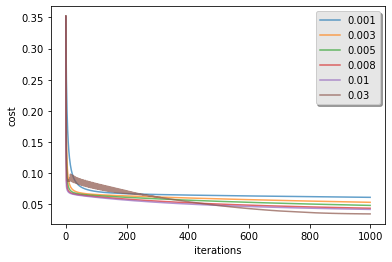

[[0.35195821 0.29094535 0.25034554 0.22162428 0.2001692  0.18346546
  0.17006466 0.15907474 0.14991042 0.14216686 0.13555215 0.12984903
  0.12489181 0.12055173 0.11672717 0.1133369  0.1103153  0.10760883
  0.10517346 0.10297266 0.10097595 0.09915771 0.09749627 0.09597321
  0.09457279 0.09328148 0.09208759 0.09098102 0.08995293 0.08899564
  0.08810237 0.08726718 0.08648482 0.08575061 0.08506043 0.08441057
  0.08379773 0.08321894 0.08267156 0.08215318 0.08166162 0.08119494
  0.08075134 0.08032923 0.07992711 0.07954364 0.0791776  0.07882786
  0.07849339 0.07817323 0.07786651 0.07757243 0.07729024 0.07701926
  0.07675883 0.07650839 0.07626737 0.07603527 0.07581161 0.07559595
  0.07538788 0.07518701 0.07499299 0.07480547 0.07462414 0.07444871
  0.07427889 0.07411444 0.07395509 0.07380062 0.07365081 0.07350546
  0.07336438 0.07322738 0.07309428 0.07296493 0.07283918 0.07271686
  0.07259786 0.07248203 0.07236925 0.0722594  0.07215237 0.07204806
  0.07194636 0.07184717 0.0717504  0.07165597 0.

In [26]:
plt.clf()

NCost = int(models[0.003]["num_iterations"])

costarray_full = np.zeros((len(learning_rates),NCost))
costarray_single = np.zeros(NCost)

#print (NCost)
for i in range(6):#len(learning_rates)):
    costarray_single = np.zeros(NCost)
    for j in range(NCost):
        #print (j)
        costarray_single[j] = np.mean(np.squeeze(models[learning_rates[i]]["costs"][j])) 
    costarray_full[i] = costarray_single
    plt.plot(costarray_full[i], label= str(models[learning_rates[i]]["learning_rate"]),alpha=0.7)
    #print (np.squeeze(models[i]["costs"][2]))

#plt.plot(costarray_full[i], label= str(models[0.001]["learning_rate"]), alpha=1)
#plt.plot(np.squeeze(models[0.001]["costs"][1]), label= str(models[0.001]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

print (costarray_full)

In [37]:
print (np.squeeze(models[0.003]["costs"][1]).shape)

(1296,)


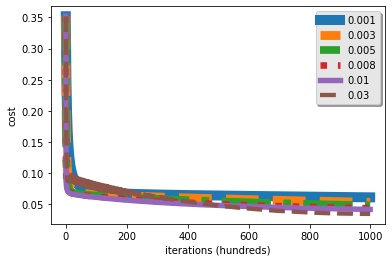

In [29]:
plt.clf()
grid=[x for x in range(1000)]
i = 0
for gg,graph in enumerate(costarray_full[0:6]):
    lw=10-8*gg/len(costarray_full)
    ls=['-','--','-.',':'][gg%4]
    plt.plot(grid,graph,label=str(models[learning_rates[i]]["learning_rate"]), linestyle=ls, linewidth=lw)
    i = i+1
    
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='best', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()